In [15]:
#Importing packages
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import HeatMap
import geopandas as gpd
import plotly.express as px
import calplot
from bokeh.plotting import *
from bokeh.models import *
from bokeh.io import output_file, show
import seaborn as sns


In [16]:
#Import data from CSV
df = pd.read_csv('Motor_Vehicle_Collisions_-_Crashes_20240409.csv')

#Date time collumn:
df['CRASH DATE'] = pd.to_datetime(df['CRASH DATE'])
df = df.sort_values(by='CRASH DATE')

# changing all cells with strings to lowercase:
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)

#Removing years 2012 and 2024
df['YEAR'] = df['CRASH DATE'].dt.year
df = df[(df['YEAR'] != 2012) & (df['YEAR'] != 2024)]


/var/folders/jp/dc7lqd6n2jj4xgt9r_fd31440000gn/T/ipykernel_3190/2538109447.py:2: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



### 1. Motivation
<!-- What is your dataset? -->
The dataset, that we have used in this project is called “Motor vehicle collisions - crashes” and it concerns vehicle crashes in the period from mid 2012 up until april 2024 in New York City (NYC). It can be found on: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95/about_data

<!-- Why did you choose this/these particular dataset(s)? -->
We have decided to analyze this particular dataset of various reasons.
1. The dataset contains no less that 2.08 datapoints. This ensures that there is more than enough data to perform well grounded anlyses.
2. The dataset contains geo-data which makes it possible to do geographical analyses of where crashes usually happens.
3. The dataset contains 29 different attributes making it possible to analyse different factors involved and how they influence the overall picture.

<!-- What was your goal for the end user's experience? -->
The goal for the end user's experience is to get insight into how and where you are more likely to experience car crashes in NYC. This can be of interest to the residents of the city or to people responsible or interested in the production of cars, struturing of the city planning or behavior analysts.



### 2. Basic stats
<span style="font-size:larger; font-weight:bold;">Data cleaning</span>
<!-- Write about your choices in data cleaning and preprocessing -->
The years 2012 and 2024 are not entire years and so they become difficult to compare with the other years. These have been left out from the dataset.

The dataset contains quite a few NaN's and extreme values in some of the columns - especially for the attributes concerning location.
However, we have decided not to delete these, as a lack of geo-data does not affect the other attributes as we process them indivually. At the same time, when mapping the data the zoom will be on the location of NYC, and so, wrong geodata will not disturb the quality of the maps.

For all columns containing strings such as 'CONTRIBUTING FACTOR VEHICLE 1' or 'VEHICLE TYPE CODE 1', we have changed all cells to lowercase letters to uniform the data. This means that cells such as 'BUS' and 'bus' will now be interpreted as the same.

<!-- Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis. -->

<span style="font-size:larger; font-weight:bold;">The dataset stats</span>

The 29 attributes cover date, time and location (both coordinates, streetname and cross street name).
Also number of people (drivers, pedestrians, cyclists) injuerd or killed as well as the contributing factor for the crash and the vehicle types involved.

To get a preliminary idea of the data we have made a few simple plots.
The first plot shows the development in crashes from 2013 to 2023. What is interesting is the drop from 2019 to 2020, which we will look further into.

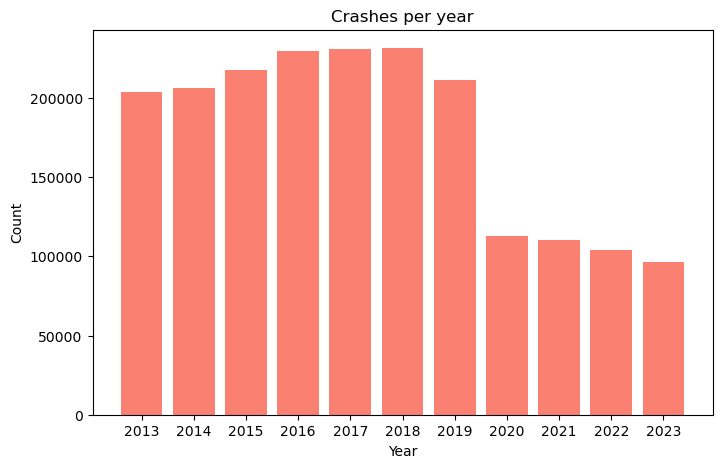

In [17]:
per_year = df['YEAR'].value_counts().sort_index()

plt.figure(figsize=(8, 5))  # Adjust the figure size if needed

# Create bar chart
plt.bar(per_year.index, per_year.values, color='salmon')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Crashes per year')
plt.xticks(per_year.index)
plt.show()

Another thing that would be interesting is to explore which contributing factors are most frequent.
As there is always at least one vehicle involved we'll use the attribute 'CONTRIBUTING FACTOR VEHICLE 1' for the exploration. A total of 62 different contributing factors can be found. However the most common one is *'unspecified'* with no less that '567.539' occurences. This is unfortunate but it will still be possible to explore some of the other factors. As some of the factors show very few occurences such as 'listening/using ueadphones' with only 21 occurences we will not be focussing on these as it is a very low frequency in a dataset of this size.
This has left us with a limited amount of factors that we have been focusses on.

### 3. Data Analysis
<!-- Describe your data analysis and explain what you've learned about the dataset. If relevant, talk about your machine-learning.-->
Starting with a very large dataset, our analysis was very wide in the beginning. We started out making many exploratory plots, to get insights into how the data was structured and to see if we could notice something of interest. We did however somewhat early in the process set on some type of data which we would like to investigate further to scope the aim of this project - these are our sections of the webpage (Contributing factor, vehicle type and location of crashes).  Some of the main findings are: 

<span style="font-size:larger; font-weight:bold;">Decrease of crashes in 2020:</span>
As seen on the barplot from the section 2.Basic stats above, we found that the datset contains information about that the number of crashes almost decreased by 50% in 2020. This could either be an indication of a flaw in the datset, but we found it to be a trend connected to the Covid pandemic, which resulted in less cars on the roads, as people worked remote. 

<span style="font-size:larger; font-weight:bold;">Inattention as contributing factor:</span>
We found that the contributing factor "unspecified" was to most frequently appearing. This may be due to that it can be hard to evaluate what caused a crash. Since it is difficult for us to analyse something from this tendency, we looked more into the other most frequently reported, which we found to be; "inattention/distraction" and "failure to yield right-of-way". 
INSERT BAR PLOT

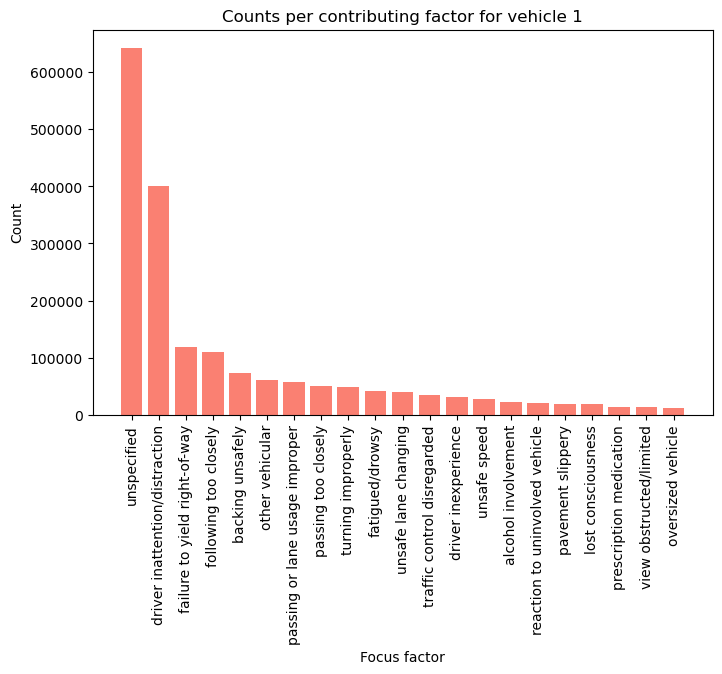

In [18]:
counts = df['CONTRIBUTING FACTOR VEHICLE 1'].value_counts().head(21)

plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts, color='salmon')
#plt.yscale('log')

# Label the axes
plt.xlabel('Focus factor')
plt.xticks(rotation = 90)
plt.ylabel('Count')
plt.title('Counts per contributing factor for vehicle 1')
# Show the plot
plt.show()

<span style="font-size:larger; font-weight:bold;">New procedures in 2016:</span>
Looking at the type of car involved, we found some strange tendencies around year 2016. As seen on the Bokeh plot for which the code is shown below (Go to the webpage to see the plot), some vehicle types have observations all years from 2013-2023, while some only have up until 2016 and some third have from 2016-2023. The datset here displays that some shift in the way the data is collected must have happened. We can however conclude that the most frequently appearing vehicle types are sedans/passenger vehicles and stationvagons/SUVs.
The Bokeh is not normalized as we found it interesting to compare the different vehicle types, which does affect the vehicle types with few occurences, such as ambulances, that is almost not possible to read.

In [19]:
df.loc[df['VEHICLE TYPE CODE 1'] == 'sport utility / station wagon', 'VEHICLE TYPE CODE 1'] = 'station wagon/sport utility vehicle'
focus_vehicles = df['VEHICLE TYPE CODE 1'].value_counts().head(18).index
focus_vehicles = focus_vehicles[focus_vehicles != '4 dr sedan']
focus_vehicles = focus_vehicles[focus_vehicles != 'other']
focus_vehicles = focus_vehicles[focus_vehicles != 'unknown']
df = df[df['VEHICLE TYPE CODE 1'].isin(focus_vehicles)]
year_vehicles = df.groupby(['YEAR', 'VEHICLE TYPE CODE 1']).size().unstack()

output_notebook()
#normalized_vehicles = year_vehicles.div(year_vehicles.sum(axis=0), axis=1)
#normalized_vehicles.index = normalized_vehicles.index.astype(str)

year_vehicles.index = year_vehicles.index.astype(str)

#df_bokeh = ColumnDataSource(normalized_vehicles)
df_bokeh = ColumnDataSource(year_vehicles)

years = [str(2013 + i) for i in range(11)]
colors = sns.color_palette("husl", len(focus_vehicles))
colors = ['#%02x%02x%02x' % (int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors]

p = figure(x_range = FactorRange(factors=years), title="Crashes per year for different vehicle types - 2013 to 2023", x_axis_label='Year', y_axis_label='Crashes', height=400, width=700) 
k = 0

bar ={}
items = []
for indx,i in enumerate(focus_vehicles):
    bar[i] = p.vbar(x='YEAR',  top=i, source = df_bokeh, width=0.7,
                      muted_alpha=0.05, muted = True, fill_color = colors[indx])

     ### for the custom legend // you need to figure out where to add it
    items.append((i, [bar[i]])) ### figure where to add it
    legend = Legend(items=items, location=(0, 0)) ## figure where to add it


p.add_layout(legend, 'left')
p.legend.click_policy="mute" ### assigns the click policy (you can try to use ''hide'


output_file('/Users/rasmuskongsted/Documents/Danmarks Tekniske Universitet/DTU/10. semester/Dataanalyse/Gitpage/raskong.github.io/Final_Project/Figures/bokeh_year_vehicles.html')
show(p) #displays your plot

Loading BokehJS ...

<span style="font-size:larger; font-weight:bold;">Alcohol involvement in the weekends and 1st of January: </span>
From analysing the contributing factor we found that most factors peak in the afternoon. The only one differing from this is alcohol involvement, since it is more frequent at night - not surprisingly. Analysing this factor deeper we found that it is most frequent during the weekend, and special (often alcohol dependent) dates such as 1st of January.

(<Figure size 1250x1870 with 12 Axes>,
 array([<Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>], dtype=object))

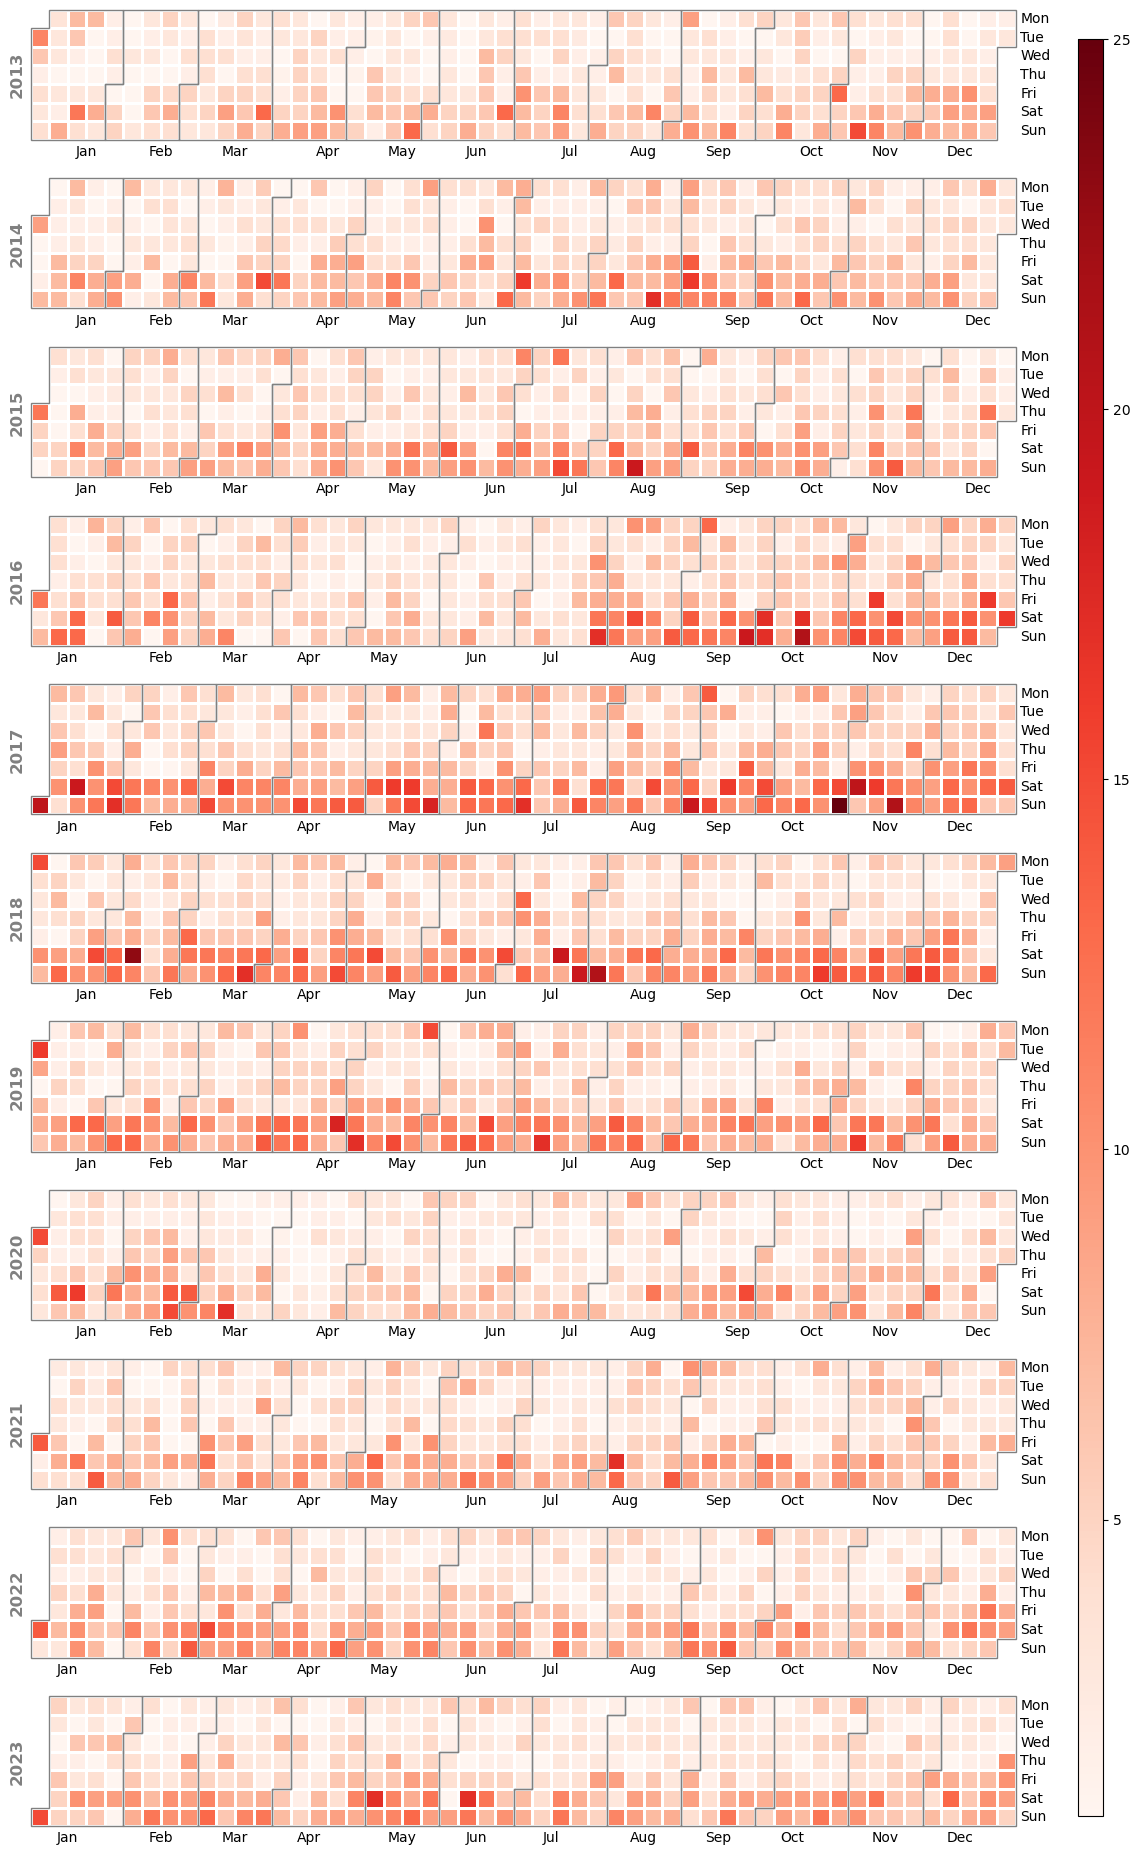

In [20]:
#create new df of crashes with alcohol involvement
Alc_df = df[df["CONTRIBUTING FACTOR VEHICLE 1"] == "alcohol involvement"].copy()

#category and obtaining values of occ per Date

Alc_date_counts = Alc_df["CRASH DATE"].value_counts()

# Convert the index to dattime format
Alc_date_counts.index = pd.to_datetime(Alc_date_counts.index)

# Resample  the data to daily freqnuency and fill missing days
Alc_daily_counts = Alc_date_counts.resample('D').first()

#interpolate
interpolated_counts = Alc_daily_counts.interpolate() 
Alc_final_counts = interpolated_counts.head(len(Alc_daily_counts))

#round the final_counts
Alc_final_counts = Alc_final_counts.round(3)

#plot using the calplot  package 
calplot.calplot(Alc_final_counts, yearlabel_kws=dict({'fontname':'sans-serif'}, fontsize=12), cmap="Reds", dropzero=False)

<span style="font-size:larger; font-weight:bold;">Densely populated areas and big roads = more crashes:</span>

Analysing the geo-data provided by the dataset, we found that most crashes happens close to/on large roads such as Broadway. This is either because it has many cars driving them each day and this causes more crashes or since the roads are longer and you therefore statistically will report a higher number of crashes. Looking at the postal codes, we found that postal codes with high density of people or the one with the junction of Broadway and Atlantic Avenue has the most crashes. The code for the plot can be seen below and the plot itself can be found on the webpage.

In [21]:
# Read the geoJSON file into a GeoDataFrame
url = "https://raw.githubusercontent.com/fedhere/PUI2015_EC/master/mam1612_EC/nyc-zip-code-tabulation-areas-polygons.geojson"
gdf = gpd.read_file(url)

# Count occurrences of each postal code
gdf['count'] = gdf['postalCode'].map(df['ZIP CODE'].value_counts())

# Change the index of the GeoDataFrame to postalCode
gdf.index = gdf['postalCode']
gdf.index.name = 'Postal Code'

# Create Plotly figure
fig = px.choropleth_mapbox(gdf, 
                           geojson=gdf.geometry, 
                           locations=gdf.index,  # Use the index as location
                           color='count',
                           color_continuous_scale="Plasma",
                           range_color=(0, gdf['count'].max()),
                           mapbox_style="carto-positron",
                           zoom=9.2, 
                           width=800,height=500,
                           center = {"lat": 40.7128, "lon": -73.99},
                           opacity=0.5,
                           labels={'count':'Number of crashes'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_html("crashesmap.html")
fig.show()

### 4. Genre
<!-- What is your dataset? 
Which genre of data story did you use?
- Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
- Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why? -->
We will now list the tools we sued to tell the data story. It will be structured after Figure 7 in Segal an Heer.
<span style="font-size:larger; font-weight:bold;">Visual narrative:</span>
1. Visual Structuring 
    1. **Consistent visual platform**<br/>
    This is the case, since there is a consistent layout throughout all the sections of the webpage. The layout of the platform is not the important thing to direct attention to, which is why we hoped that a consistency would lead the reader's attention to the content instead. 
2. Highlighting
    1. **Feature distinction**<br/>
    We try to guide the readers eye to the visualizations through adding colorful plots. This both attract the eye and gives immediate indication on what story we would like to tell. 
    2. **Motion/Audio**<br/>
    We added the video we created for part A, to let the reader experience the purpose of the webpage in a lighter and more entertaining way.  
3. Transition guidance
    1. **Familiar object**<br/>
    The webpage has a smooth transition from section to section due to the similar object on each page(layout) but has not much direct transition between them. The panel is a well-known feature which most people would find familiar and know how to maneuver.


<span style="font-size:larger; font-weight:bold;">Narrative structure:</span>
1. Ordering
    1. **Random access** <br/>
    We have chosen the panel to let the user inspect the page in a non-structured way allowing them to explore the parts of the data story they find the most interesting. They can therefore freely jump between sections. However, in many cultures a standard would be to access the sections from left to right, which is why we have ordered the to fit this direction of reading. All sections are however able to stand alone.
2. Interactivity 
    1. **Hover highlighting** <br/>
    In the postal code map you can hover over the postal codes and get the information about the number of car crashes. It  would simply have been too messy if it was indicated permanently on the map because of the big amount of data, which is why we have chosen the hover highlighting
    2. **Filtering/selection/search** <br/> 
    On the Bokeh plots you are allowed to select the type of contributing factor you would like to inspect. This gives the reader an option to compare the patterns of the factors themselves which will make the story/insights more memorable.  
    3. **Navigation buttons** <br/>
    The already mentioned panel allows the user to interact with the webpage. 
    4. **Stimulating Default Views** <br/>
    The heatmap is clearly zoomed in on an area which we have chosen of interest and we have helped the reader by pointing some locations out in the map where there is a special density of crashes. This default view was chosen to guide the story we would like to tell, but the story is still interactive, allowing the reader to e.g. look up the surrounding area of their home, work etc. 
3. Messaging 
    1. **Captions** <br/>
    All the different sections and subsections have big heading to attract focus and give overview of the foloowing content
    2. **Introductory text** <br/>
    The first section "Home" is made with introductory text giving an insight into what the webpage will cover
    

### 5. Visualizations
<!-- What is your dataset?
- Explain the visualizations you've chosen.
- Why are they right for the story you want to tell? -->

<span style="font-size:larger; font-weight:bold;">Video</span> <br/>
We added the video from the Final A delivery. Both because we already had it, but also since we thought it made great sense to invite the reader to get a better understanding of the purpose of the analysis through a visual appealing format where they are guided through the content in a speed and structure 100% defined by us. 

<span style="font-size:larger; font-weight:bold;">Bar plots</span> <br/>
Bar plots are used several times (crashes per year, contributing factor, vehicle type). This is a simple way of visualizing a comparision between several types of observations. 


<span style="font-size:larger; font-weight:bold;">Bokeh plot</span> <br/>
This format has been used to let the reader interact with the data and investigate the findings through the ability to select special factors of interest. We used it for contributing factor and vehicle type over the years. Here the reader gets an indication of e.g. how big the difference is between the occurrences of station wagon and taxi crashes while they also get information about the development over the years. 

<span style="font-size:larger; font-weight:bold;">Sub plots</span> <br/>
We chose a subplot of bar plots to visualize the occurrences of the contributing factors per hour of the day. This could have been done as a bokeh plot if we wanted the reader to interact with the data, but we chose this format since you very fast get an overview of that almost all contributing factors have the same pattern of occurrences. Further it is a fast way of visualizing that alcohol involvement is the only factor which differs from the rest. There would have been a risk of the reader not noticing this if it had been a bokeh plot.

<span style="font-size:larger; font-weight:bold;">Calendar plots</span> <br/>
This type of plot is used to further investigate the pattern of alcohol as a contributing factor. It was used to visualize the tendency in that alcohol contributes more frequently in the weekends but also to visualize that some specific days, such as 1st of January, are more likely to have observations of this contributing factor. The plot type therefore offers individual observations of days and not just an average of weekdays over a year or a larger period of time. 


<span style="font-size:larger; font-weight:bold;">Scatterplot with variable size</span> <br/>
When dealing with a lot of decrete data an usual scatterplot would quickly be overplotting and hidding some of data, caused by that the scatters would be drawn on top of each other. Insted we can scale the dots with the count showing an extra dimension of the plot. We made this kind of plot to see the distribution of vehicle type vs. contribution factor and to see if there is a more destructive kind of vehicle when it come to injured persons.   



<span style="font-size:larger; font-weight:bold;">Choropleth map</span> <br/>
Mapping out the geographical patterns of crashes is done though a choropleth map. This divides the map of NYC up into sections (we chose postal codes). This was chosen since the individual observations are difficult to get a grasp of, and the grouping of these into geographical locations and color coding them gives the reader a better understanding of if any locations of NYC have a higher probability of crashes and how much larger it is. We could have chosen broughs or other ways of dividing NYC into parts, but chose postal codes since they are smaller and are more or less the same size which minimize the interpretation error, which can happen from that larger areas are more likely to have more observations. 

<span style="font-size:larger; font-weight:bold;">Heatmap</span> <br/>
Heatmap was used to get a more detailed visualization of where in the city the observations of crashes occur. This mapping method was difficult to use for all the data, since there were too many observations. We therefore chose to only look at fatal crashes (involving killed people) and data for the most frequently occurring vehicle type (station wagon). This made it possible to visualize if any specific roads or areas were more frequently occurring - which it turned out wasn't significant. 



### 6. Discussion. 
<!-- What is your dataset? 
Think critically about your creation 
- What went well?,
- What is still missing? What could be improved?, Why? -->


Overall we believe that we have managed to create a good analysis of the chosen dataset. We have at least all experienced satisfaction in having used many of the tools and techniques we have learned in the course. However, the dataset turned out to be a bit tricky to work with. We realized that it wasn’t only a good thing that it was a very big dataset, as it had sevral flaws like strange naming of labels, missing data and changed way of noting incidents over the years.

<span style="font-size:larger; font-weight:bold;">Naming of factors</span> <br/>
Many of the observations were categorized in different terms but covered the same type of observations. As an example, we found that both “station wagon/sport utility vehicle” and “sport utility/station wagon” were present as different types of cars. Here we just merged the two types of observations into one, but we are aware that if we had to continue working with this dataset, we should go through all the observations and ensure that it didn’t have more misleading naming of the factors as this.

<span style="font-size:larger; font-weight:bold;">Missing data</span> <br/> 
Further we found several holes in the observations. Looking at the bokeh plot for the contributing factors you can conclude that e.g. both: “Passing too closely”, “Unsafe lane changing”, and “Following too closely” weren’t present in the years before 2016. We don’t believe that this is the actual case but rather that they just started noting these observations in 2016. This would be something we would have to investigate further if we had to continue working with the data. 


<span style="font-size:larger; font-weight:bold;">Mostly discrete data</span> <br/> 
Their is a general lack of continuous data. Witch narrows the possibilities types of plot we can make. If we were to repeat this assignment, we would prefer to locate another dataset that fulfills this requirement.



<span style="font-size:larger; font-weight:bold;">Geo-data</span> <br/> 
Using the geo-data we managed to get overall insights into if any geographical trends appear concerning the frequency of car crashes. We did however not find many specific areas of interest as “hoped”.  We could, from this analysis therefore not give very justified recommendations to where you would have to improve the city planning/road systems to improve safety in NYC. A more in depth analysis of which contributing factors lead to crashes and where could be interesting to conduct. As an example we could imagine that “failure to yield right-of-way” had something to do with the location of which it happens. 


### 7. Contributions. Who did what?

Explainer: Lin, Mads, Rasmus

Webpage setup: Lin, Mads, Rasmus

Home: Rasmus, Mads

Data Overview: Rasmus

Contributing Factor: Rasmus, Mads

Vehicle type: Rasmus, Mads

Location of Crashes: Lin